<a href="https://colab.research.google.com/github/WoradeeKongthong/ComputerVision/blob/master/CV_Model_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG Blocks

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from IPython.display import Image 
import matplotlib.pyplot as plt

In [7]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

In [13]:
# create model with Functional API

# define model input
visible = Input(shape=(256, 256, 3))

# add 1 vgg module
layer = vgg_block(visible, 64, 2)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
# create model (3 VGG blocks)
# define model input
visible = Input(shape=(256, 256, 3))

# add 1 vgg module
layer = vgg_block(visible, 64, 2)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 256, 4)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)       0   

# Naive Inception Module
A block of parallel convolutional layers with 'different' sized filters (e.g. 1x1, 3x3, 5x5)  
and a 3x3 max pooling layer,  
the results of which are then concatenated.


In [15]:
from keras.layers.merge import concatenate

In [16]:
# function for creating a naive inception block
def naive_inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [17]:
# define model input
visible = Input(shape=(256, 256, 3))

# add inception module
layer = naive_inception_module(visible, 64, 128, 32)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 64) 256         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 128 3584        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 2432        input_7[0][0]                    
____________________________________________________________________________________________

# Optimized Inception Module
To use many inception modules in your model, you need to **control number of filters**
*   prior to the 3x3 conv
*   prior to the 5x5 conv
*   after max pooling

In [19]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [20]:
# define model input
visible = Input(shape=(256, 256, 3))

# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)

# add inception block 2
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 96) 384         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 64          input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 3)  0           input_9[0][0]                    
____________________________________________________________________________________________

# Residual Module
The output of the second layer is added with the input to the first conv layer.  
Called a shortcut connection.

In [21]:
from keras.layers import Activation, add

In [22]:
# function for creating a residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	
  # conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	
  # add first layer input to second layer output
	layer_out = add([conv2, merge_input])
 
	# activation function
	layer_out = Activation('relu')(layer_out)
 
	return layer_out

In [23]:
# define model input
visible = Input(shape=(256, 256, 3))

# add vgg module
layer = residual_module(visible, 64)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 256, 256, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 256, 256, 64) 256         input_10[0][0]                   
____________________________________________________________________________________________

# Transfer Learning
A process where a model trained on one problem is used in some way on a second, related problem.  

How to use pre-trained models.
1.   **Classifier** : use directly  
     `model = VGG16()`
2.   **Standalone Feature Extractor** : use to pre-process images and extract features  
3.   **Integrated Feature Extractor** : integrated into a new model but not be trained  
      `model = VGG16(include_top=False, input_tensor=Input(shape=(256,256,3)), pooling='avg')`  
      Then set layers trainable=False
4.   **Weight Initializer** : integrated into a new model and be trained  (FINE TUINING)
5.   **Only Architecture** : use only architecture, not included weights  
      `model = VGG16(weights=None, input_tensor=Input(shape=(256,256,3)), classes=10)`

Models for Transfer Learning
*   VGG19, VGG19
*   InceptionV3
*   ResNet50

## Load VGG16 Pre-trained Model
default input shape : (224, 224, 3)

In [24]:
from keras.applications.vgg16 import VGG16

# load model
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 179s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

## Load ResNet50
default input shape : (224, 224, 3)

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50

#load model
model = ResNet50()
model.summary()

102981632/102967424 [==============================] - 68s 1us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________

## Pre-Trained Model as Classifier (VGG16)

In [27]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
from matplotlib import pyplot as plt

In [29]:
# load an image
img = load_img('data/cat.jpg', target_size=(224,224))
# convert img to array
pixels = img_to_array(img)
print(pixels.shape)
# reshape data for the model
pixels = np.expand_dims(pixels,0)
print(pixels.shape)
# preprocess the image fot the VGG16
pixels = preprocess_input(pixels)

(224, 224, 3)
(1, 224, 224, 3)


In [30]:
# load model
model = VGG16()

[[('n02123045', 'tabby', 0.43784803), ('n02124075', 'Egyptian_cat', 0.37134245), ('n02123159', 'tiger_cat', 0.17436716), ('n02127052', 'lynx', 0.0030451152), ('n03223299', 'doormat', 0.00084034353)]]


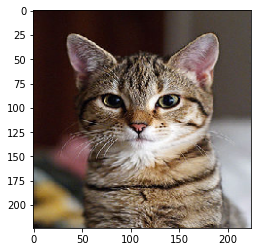

In [38]:
# predict the probability across all output classes
probs = model.predict(pixels)
# convert probability to class label
label = decode_predictions(probs)

# retrieve the most likely result (highest probability)
#label = label[0][0]

print(label)
plt.imshow(img)
plt.show()

## Pre-Trained VGG16 as Feature Extractor Preprocessor

In [39]:
from keras.models import Model
from pickle import dump

In [41]:
# load an image
img = load_img('data/cat.jpg', target_size=(224,224))
# convert img to array
pixels = img_to_array(img)
# reshape data for the model
pixels = np.expand_dims(pixels,0)
# preprocess the image fot the VGG16
pixels = preprocess_input(pixels)
print(pixels.shape)

(1, 224, 224, 3)


In [45]:
# load model
model = VGG16()

# remove the output layer
# model.layers.pop() # not working
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [47]:
# get extracted features
features = model.predict(pixels)
print(features.shape)

# save features as pickle file
dump(features, open('data/catfeature.pkl','wb'))

(1, 4096)


Note : then we can use this feature as input of the model

## Pre-Trained VGG16 as Feature Extractor in Model

2 approaches
1.   VGG16(include_top=False,...) then add Flatten(),and Dense()
2.   VGG16(include_top=False,...,pooling='avg') then add Dense()

In [48]:
from keras.layers import Dense, Flatten

In [49]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300,300,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [50]:
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False

# OR mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False

In [51]:
# add new classifier part
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

# define model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0  

Note : Then train the model